## Telling birds from airplanes using conv
For our CIFAR-10 data, we will resort to nn.Conv2d. At a minimum, the arguments we provide to nn.Conv2d are the number of input features, the number of output features, and the size of kernel. For instance, for our first convolutional module, we'll have 3 input features per pixel (RGB) and an arbitrary number of channels in the output-say, 16. The more channels in the output image, the more the capacity of the network. We need the channels to be able to detect many different types of features. Also, because we are randomly initializing them, some of the features we'll get, even after training, will turn out to be useless. Let's stick to a kernel size $3\times 3$.

In [1]:
import torch.nn as nn

conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

For a single output pixel value, our kernel would consider, say in\_ch=3 input channels, so the weight component for a single output pixel value is of shape $in\_ch\times 3\times 3$. Finally, we have as many of those as we have output channels, here out\_ch=16, so the complete weight tensor is $out\_ch\times in\_ch \times 3\times 3$, in our case, $16\times 3\times 3\times 3$. The biase will have size 16. Let's verify:

In [2]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

A 2D convolution pass produces a 2D image as output, whose pixels are a weighted sum over neighborhoods of the input image. In our case, both kernel weights and the bias conv.weight are initialized randomly, so the output image will not be particularly meaningful. As usual, we need to add the zeroth batch dimension with unsqueeze if we want to call the conv module with one input image, since nn.Conv2d expects a $B\times C\times H\times W$ shaped tensor as input:

In [3]:
from torchvision import datasets
from torchvision import transforms

data_path = '../../dlp_es/CIFAR-10/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                           transform=transforms.Compose([transforms.ToTensor(),
                                                         transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                                              (0.2470, 0.2435, 0.2616))]))

cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                               transform=transforms.Compose([transforms.ToTensor(),
                                                             transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                                                  (0.2470, 0.2435, 0.2616))]))

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]

cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [4]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Display the output:

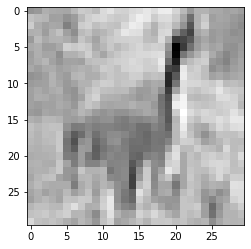

In [5]:
from matplotlib import pyplot as plt
import numpy as np

plt.imshow(output[0,0].detach(), cmap='gray')

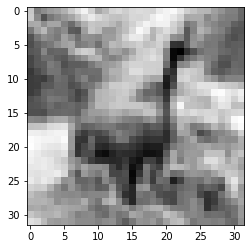

In [6]:
# input img
plt.imshow(img.unsqueeze(0)[0,0], cmap='gray')

In [7]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

### Dectecing features with convolutions
weight and bias are parameters that are learned through back-propagation. However, we can play with convolution by setting weights by hand and see what happens. Let's first zero out bias, just to remove any confounding factors, and then set weights to a constant value so that each pixel in the output gets the mean of its neighbors. For each $3\times 3$ neighborhood:

In [8]:
import torch

with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

Let's see the effect on our CIFAR image:

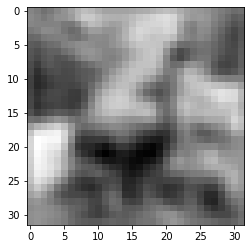

In [9]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap='gray')

As we can predict, the filter produces a blurred version of the image. After all, every pixel of the output is the average of a neightborhood of the input, so pixel in the output are correlated and change more smoothly.

edge-dectection kernel, have already been talked about in image processing.

Max pooling is provided by the nn.MaxPool2d module. It takes as input size of the neighborhood over which to operate the pooling operation. If we wish to downsample our image by half, we'll want to use a size of 2

In [10]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

/home/ubuntu/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

Putting it all together for our network. Let's take our previous fully connected model as a starting point and introduce nn.Conv2d and nn.MaxPool2d as described previously:

In [11]:
model = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1),
                      nn.Tanh(), 
                      nn.MaxPool2d(2),nn.Conv2d(16, 8, kernel_size=3, padding=1),
                      nn.Tanh(),
                      nn.MaxPool2d(2),
                      #
                      nn.Linear(8 * 8 * 8, 32),
                      nn.Tanh(),
                      nn.Linear(32, 2))

Where does this end? After the input image has been reduced to a set of $8\times 8$ features, we expect to output some probabilities from the network that we can feed to our negative log likelihood. However, probabilities are a pair of numbers in a 1D vector, but here we're still dealing with multichannel 2D features.

Let's count the number of parameters for this small model:

In [12]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [ ]:
model(img.unsqueeze(0))

# RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

What's missing here is the reshaping step from an 8-channel $8\times 8$ image to a 512-element, 1D vector. This could be achieved by calling $view$ on the output of the last nn.MaxPool2d, but unfortunately, we don't have any explicit visibility of the output each module when we use nn.Sequential

### Subclassing nn.Module
In this section, we learn how to make our own nn.Modules subclass that we can then use just like the prebuilt ones or nn.Sequential

In order to subclass nn.Module, at a minimum we need to define a $forward$ function that takes the inputs to the module and returns the output. This is where we define our module's computation. The name $forward$ here is reminiscent of a distant past, when module needed to define both forward and backward passes we met. With Pytorch, if we use standard $torch$ operations, $autograd$ will take care of the backward pass automatically, and indeed, an nn.Module never comes with a $backward$.

To include these submodules, we typically define them in the constructor \_\_init\_\_ and assign them to $self$ for use in the forward function.

In [14]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [15]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

Thus, the funcitonal way also sheds light on what the nn.Module API is all about: a Module is a container for state in the forms of $Parameters$ and submodules combined with the instructions to do a forward.

Now let's double-check the constructor, then we will get to the training loop.

In [16]:
model = Net()
model(img.unsqueeze(0))

tensor([[ 0.0295, -0.0812]], grad_fn=<AddmmBackward>)

### Training our convnet
Recall that the core of our convnet is two nested loops: an outer one over the $epochs$ and an inner one of the $DataLoader$ that produces batches from our $Dataset$. In each loop, we have to:
1. Feed the inputs through the model (the forward pass)
2. Compute the loss (also the part of forward)
3. Zero any old gradients
4. Call loss.backward() to compute the gradients of the loss with respect to all parameters (the backward pass)
5. Have the optimizer take a step in toward lower loss

In [17]:
import torch.optim as optim
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(),
                                                         epoch,
                                                         loss_train / len(train_loader)))

In [18]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss() 

training_loop(n_epochs = 100,
              optimizer = optimizer,
              model = model,
              loss_fn = loss_fn,
              train_loader = train_loader,)

2021-09-07 15:54:30.657029 Epoch 1, Training loss 0.5747680984864569
2021-09-07 15:54:47.666738 Epoch 10, Training loss 0.34377605349394924
2021-09-07 15:55:06.850869 Epoch 20, Training loss 0.2979713445825941
2021-09-07 15:55:25.740623 Epoch 30, Training loss 0.26846208893189766
2021-09-07 15:55:44.622790 Epoch 40, Training loss 0.2478628640721558
2021-09-07 15:56:03.803131 Epoch 50, Training loss 0.22938775921323498
2021-09-07 15:56:23.191011 Epoch 60, Training loss 0.2131030573776573
2021-09-07 15:56:41.829981 Epoch 70, Training loss 0.1994749170484816
2021-09-07 15:57:00.895225 Epoch 80, Training loss 0.18499586674248336
2021-09-07 15:57:20.425126 Epoch 90, Training loss 0.17100826195281021
2021-09-07 15:57:41.022772 Epoch 100, Training loss 0.1582068313079275


Measuring the accuracy: in order to have a measure that is more interpretable than the loss, we can take a look at our accuracies on the training and validation datasets.

In [21]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted==labels).sum())
        
        print("Accuracy {}: {:.2f}".format(name , correct / total))
    
validate(model, train_loader, val_loader)

Accuracy train: 0.92
Accuracy val: 0.87


We about halved the number of errors on the validation set. Also, we used far fewer parameters. This is telling us that the model does a better job of generalizing its task of recognizing the subject of images from a new sample, through locality and translation invariance.

Saving and loading our model: Let's save the model to a file

In [22]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

The birds_vs_airplanes.pt file now contains all the parameters of the $model$: that is, weights and biases for the two convolution modules and the two linear modules. So, no structure-just the weights. This means when we deploy the model in production for our friend, we'll need to keep the $model$ class handy, create an instance, and then load the parameters back into it:

In [23]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path+'birds_vs_airplanes.pt'))

<All keys matched successfully>